In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.optim as optim

In [3]:
root = '/kaggle/input/mvtec-ad'
category = 'cable'
dataset = os.path.join(root,category)
train_dataset = os.path.join(dataset,'train')
test_dataset = os.path.join(dataset,'test')

In [4]:
#Image processing
transform_func = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform_func = transforms.Compose([
transforms.Resize((128,128)),
transforms.ToTensor()
])

In [5]:
#load_dataset
train_dataset = ImageFolder(root=train_dataset,transform=transform_func)
test_dataset = ImageFolder(root=test_dataset,transform=test_transform_func)

In [6]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 224
    Root location: /kaggle/input/mvtec-ad/cable/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [7]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 150
    Root location: /kaggle/input/mvtec-ad/cable/test
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [8]:
#loader
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=16,shuffle=False)

In [9]:
image,label = train_dataset[20]

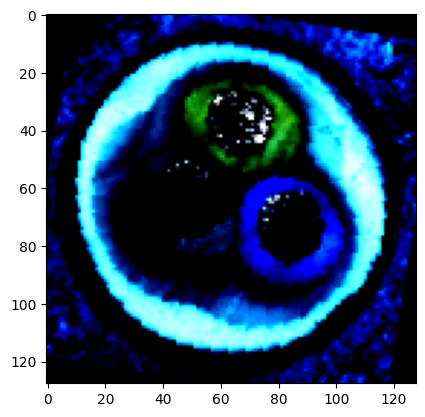

In [10]:
plt.imshow(image.permute(1,2,0).numpy())

In [11]:
#AE
class AE(nn.Module):
    def __init__(self):
        super(AE,self).__init__()
        #Encoder 
        self.encoder = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.2),
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.2),
        )
        #Bottleneck
        self.bottleneck = nn.Conv2d(64,128,3,1,1)
        self.decoder = nn.Sequential(
            nn.Conv2d(128,64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64,32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32,16,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(16,3,3,1,1),
            nn.Sigmoid()
        )

    def forward(self,x):
        x = self.encoder(x)
        x = self.bottleneck(x)
        x = self.decoder(x)
        return x

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetAE(nn.Module):
    def __init__(self):
        super(UNetAE, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU()
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU()
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU()
        )

        self.pool = nn.MaxPool2d(2, 2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU()
        )

        # Decoder
        self.up3 = nn.Upsample(scale_factor=2, mode='nearest')
        self.dec3 = nn.Sequential(
            nn.Conv2d(128 + 64, 64, 3, padding=1), nn.ReLU()
        )

        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.dec2 = nn.Sequential(
            nn.Conv2d(64 + 32, 32, 3, padding=1), nn.ReLU()
        )

        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.dec1 = nn.Sequential(
            nn.Conv2d(32 + 16, 16, 3, padding=1), nn.ReLU()
        )

        self.final = nn.Conv2d(16, 3, 1)  # output 3 channels
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)  # [B,16,H,W]
        p1 = self.pool(e1) # downsample

        e2 = self.enc2(p1) # [B,32,H/2,W/2]
        p2 = self.pool(e2)

        e3 = self.enc3(p2) # [B,64,H/4,W/4]
        p3 = self.pool(e3)

        # Bottleneck
        b = self.bottleneck(p3)  # [B,128,H/8,W/8]

        # Decoder
        d3 = self.up3(b)          # upsample
        d3 = torch.cat([d3, e3], dim=1)  # concat skip connection
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        out = self.final(d1)
        out = self.sigmoid(out)

        return out


In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
# model = AE().to(device)
model = UNetAE().to(device)

In [15]:
model

UNetAE(
  (enc1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (enc2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (enc3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (up3): Upsample(scale_factor=2.0, mode='nearest')
  (dec3): Sequential(
    (0): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (up2): Upsample(scale_factor=2.0, mode='nearest')
  (dec2): Sequential(
    (0): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (up1): Upsample(scale_factor=2.0, mode='nearest')
  (dec1): Sequential(
    (0): Conv2d(48, 

In [16]:
#hyperparams
optimizer = optim.Adam(model.parameters(),lr=1e-03)
loss_fn = nn.MSELoss()
epochs=25

In [17]:
train_losses = []
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images,_ in train_loader:
        images = images.to(device)
        pred = model(images)
        loss = loss_fn(pred,images)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    avg_loss = train_loss/len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch: {epoch} | Loss: {avg_loss}')

Epoch: 0 | Loss: 1.3575108051300049
Epoch: 1 | Loss: 1.0910861662455968
Epoch: 2 | Loss: 1.0969540902546473
Epoch: 3 | Loss: 1.097740650177002
Epoch: 4 | Loss: 1.0972560133252824
Epoch: 5 | Loss: 1.0870860304151262
Epoch: 6 | Loss: 1.1042652981621879
Epoch: 7 | Loss: 1.0935066086905343
Epoch: 8 | Loss: 1.1006316116877966
Epoch: 9 | Loss: 1.0949286222457886
Epoch: 10 | Loss: 1.0908253533499581
Epoch: 11 | Loss: 1.087202685219901
Epoch: 12 | Loss: 1.098198652267456
Epoch: 13 | Loss: 1.08786826474326
Epoch: 14 | Loss: 1.0906144380569458
Epoch: 15 | Loss: 1.096722892352513
Epoch: 16 | Loss: 1.0953453268323625
Epoch: 17 | Loss: 1.0910933698926653
Epoch: 18 | Loss: 1.0915250267301286
Epoch: 19 | Loss: 1.0936531169073922
Epoch: 20 | Loss: 1.0902598925999232
Epoch: 21 | Loss: 1.09600796018328
Epoch: 22 | Loss: 1.0975369385310583
Epoch: 23 | Loss: 1.1015206234795707
Epoch: 24 | Loss: 1.0946564674377441


In [18]:
train_losses

[1.3575108051300049,
 1.0910861662455968,
 1.0969540902546473,
 1.097740650177002,
 1.0972560133252824,
 1.0870860304151262,
 1.1042652981621879,
 1.0935066086905343,
 1.1006316116877966,
 1.0949286222457886,
 1.0908253533499581,
 1.087202685219901,
 1.098198652267456,
 1.08786826474326,
 1.0906144380569458,
 1.096722892352513,
 1.0953453268323625,
 1.0910933698926653,
 1.0915250267301286,
 1.0936531169073922,
 1.0902598925999232,
 1.09600796018328,
 1.0975369385310583,
 1.1015206234795707,
 1.0946564674377441]

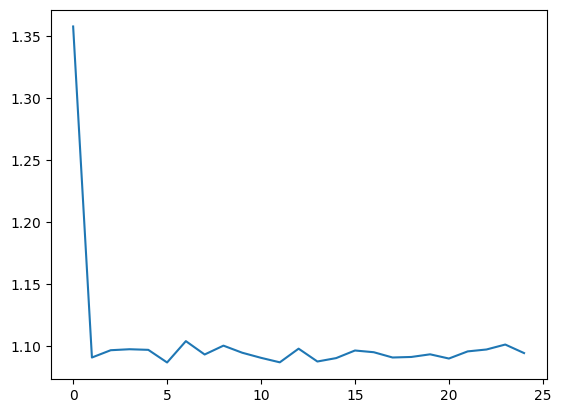

In [19]:
plt.plot(train_losses)

In [20]:
model.eval()
all_labels = []
all_scores = []

with torch.no_grad():
    for imgs,labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)

        #compute error
        errors = torch.mean((outputs-imgs)**2,dim=(1,2,3))
        all_scores.extend(errors.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        

In [21]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

all_scores = np.array(all_scores).reshape(-1, 1).flatten()
all_labels = np.array(all_labels)

# scaler = MinMaxScaler() #scaling is optional
# norm_scores = scaler.fit_transform(all_scores).flatten()





In [22]:
binary_labels = np.array([0 if l == 0 else 1 for l in all_labels])

In [23]:
#Calculate threshold and pred
threshold = np.percentile([score for label,score in zip(binary_labels,all_scores) if label==0],95)

pred = [1 if score > threshold else 0 for score in all_scores]

In [24]:
from sklearn.metrics import roc_auc_score, roc_curve,accuracy_score,classification_report

auc = roc_auc_score(binary_labels, all_scores,multi_class="ovr")
print(f"ROC AUC: {auc:.4f}")

ROC AUC: 0.5710


In [25]:
print(classification_report(binary_labels, pred))

              precision    recall  f1-score   support

           0       0.10      0.92      0.18        13
           1       0.97      0.22      0.36       137

    accuracy                           0.28       150
   macro avg       0.53      0.57      0.27       150
weighted avg       0.89      0.28      0.34       150



In [26]:
accuracy_score(binary_labels, pred)

0.28

In [27]:
torch.save(model.state_dict(), 'unet_ae.pth')
